In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import scipy.optimize as opt
import scipy.linalg as linalg
import sklearn.linear_model
import sklearn.model_selection
import pandas as pd
from sklearn.datasets import make_blobs
from sklearn.datasets import load_iris
from IPython.display import Markdown as md
from gensim.models import KeyedVectors
import warnings
warnings.filterwarnings('ignore')

# Applied Machine Learning

## Non-parametrics

parametric: data -> assumptions + model with parameters -> predictions/inference

non-parameteric: data -> inference

In [3]:
model = KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin', binary=True)

### Embeddings

- Last time we talked about efficient way to encode words
- We didn't discuss how to use these vectors though

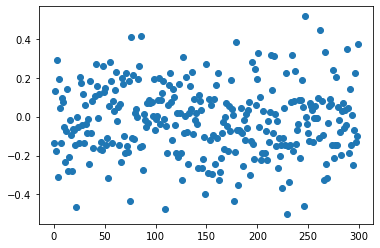

In [4]:
vector = model.get_vector('embedding'); plt.scatter(range(len(vector)), vector);

### Distributed representation

- Word embeddings are examples of distributed representation
- The meaning is in all the features
- There is no meaning of any single feature (most of the time)
- Can we apply decision tree for such data?

### Locality

- The number of possible cases in distributed representation would make learning impossible
- Embeddings of similar words differ *not that much*
- We need a method that would enjoy this property

What are the synonyms of **happy**?

In [5]:
model.most_similar('happy', topn=5)

[('glad', 0.7408890724182129),
 ('pleased', 0.6632171869277954),
 ('ecstatic', 0.6626912355422974),
 ('overjoyed', 0.6599286198616028),
 ('thrilled', 0.6514049768447876)]

What are the synonyms of **angry** then?

In [6]:
model.most_similar('angry', topn=10)

[('irate', 0.8138924837112427),
 ('enraged', 0.770506739616394),
 ('indignant', 0.701343297958374),
 ('incensed', 0.688130795955658),
 ('annoyed', 0.6847162246704102),
 ('agitated', 0.6821001768112183),
 ('frustrated', 0.6720573306083679),
 ('furious', 0.6702252626419067),
 ('unhappy', 0.6646261811256409),
 ('outraged', 0.6598437428474426)]

### Word sentiment

- Let us consider a problem of classifying words by their sentiment
- We have a list of words that are marked positive or negative

In [16]:
positive_words = ['happy', 'irritated', 'wonderful']
negative_words = ['angry', 'delighted']

### Nearest neighbor

- The simplest approach for classification: assign the label of the nearest object

In [17]:
word = 'irritated'
positive_distance = min([model.distance(word, x) for x in positive_words if x in model])
negative_distance = min([model.distance(word, x) for x in negative_words if x in model])
if positive_distance < negative_distance:
    print(word, 'is', 'positive', positive_distance, negative_distance)
else:
    print(word, 'is', 'negative', negative_distance, positive_distance)

irritated is positive 0.0 0.3444427251815796


### Engineering the distance

- The distance between two word embeddings is computed via cosine
- What is the distance for usual features we have?

In [14]:
?distance([1.0, 2.0], [3.0, 2.5])

Object `distance([1.0, 2.0], [3.0, 2.5])` not found.


### Euclidean distance

- The most widely used distance
- Requires normalization
- Doesn't like noisy features much

In [15]:
np.sqrt(np.sum((np.array([1.0, 2.0]) - np.array([3.0, 2.5]))**2))

2.0615528128088303

### Pitfalls

- Distance should be engineered carefully
- Does the method treat noisy data well?

### k nearest neighbor

- An extension of the nearest neighbor method that everyone uses
- The word's sentiment is positive if most of it's $k$ similar ones are positive
- Homework: How does the complexity change if we change $k$?
- Complexity: k in nearest neighbor, depth in decision trees, alpha/C in linear models

In [19]:
from sklearn.neighbors import KNeighborsRegressor

### Fast neighbor search

In [20]:
knn = KNeighborsRegressor(algorithm='kd_tree')
knn

KNeighborsRegressor(algorithm='kd_tree')

### When is it a good idea to use kNN?

- You have numerical data that you can normalize
- You believe to have no useless features
- The dimensionality is not that high
- Usually it is good addition to your ensemble

### The 'Concrete' dataset

In [18]:
df = pd.read_excel('Concrete_Data.xls')
df.head()

,Cement (component 1)(kg in a m^3 mixture),Blast Furnace Slag (component 2)(kg in a m^3 mixture),Fly Ash (component 3)(kg in a m^3 mixture),Water (component 4)(kg in a m^3 mixture),Superplasticizer (component 5)(kg in a m^3 mixture),Coarse Aggregate (component 6)(kg in a m^3 mixture),Fine Aggregate (component 7)(kg in a m^3 mixture),Age (day),"Concrete compressive strength(MPa, megapascals)"
0,540.0,0.0,0.0,162.0,2.5,1040.0,676.0,28,79.986111
1,540.0,0.0,0.0,162.0,2.5,1055.0,676.0,28,61.887366
2,332.5,142.5,0.0,228.0,0.0,932.0,594.0,270,40.269535
3,332.5,142.5,0.0,228.0,0.0,932.0,594.0,365,41.052780
4,198.6,132.4,0.0,192.0,0.0,978.4,825.5,360,44.296075


Let's prepare the data, split into train/test/validation and train the model

### Adding more complexity

- The main parameter is $k$, the number of nearest neighbors to consider
- We don't use distance much yet:

In [19]:
KNeighborsRegressor(weights='distance')

KNeighborsRegressor(weights='distance')

### Weights of instances

- What if we had weights for instances?
- We might try to come up with a rule for instance weights 
- The best possible thing would be to optimize these weights directly

### Support Vector Machine

- Family of methods that are based on idea to learn the weights of training examples (vectors)
- Linear: SGD + hinge loss
- Here we consider non-linear (kernel)
- The vectors that have non-zero weights are *support* ones

In [20]:
from sklearn.svm import SVR

### Kernels

- Instead of choosing the distance, in SVM you choose the kernel
- Kernel is a measure of similarity
- The usual choice is gaussian kernel (RBF)

### How's that non-parametric?

- Linear models and decision trees are constructing something out of the training data
- All the methods we just considered are using the training data itself
- Using the data and making predictions out of it directly is called non-parametric

### Pros and cons

- Can work on small datasets pretty well
- Would not scale to really large datasets
- Do not work well on mixed type data, do not handle missing values, etc
- Some methods are theoretically grounded